# Regresion Basica: Predecir eficiencia de gasolina

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.11.0


## El set de Datos de MPG

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Obtenga los datos
Primero descargue el set de datos.

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data",
                                    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\rocio\\.keras\\datasets\\auto-mpg.data'

Importelo usando pandas.

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Limpia los datos

Trata los missings y variables categóricas

In [167]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [157]:
dataset.shape

(398, 8)

In [5]:
df=dataset.copy()
df=pd.get_dummies(df,columns=["Origin"],drop_first=True)
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0


### Divide los datos en train y test

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

NOTA: El resultado tienen que ser dos datasets

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test= train_test_split(X, y, test_size=0.2, random_state=0)

NameError: name 'X' is not defined

In [159]:
X_train.shape

(318, 7)

### Inspecciona los datos

Revise rapidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos

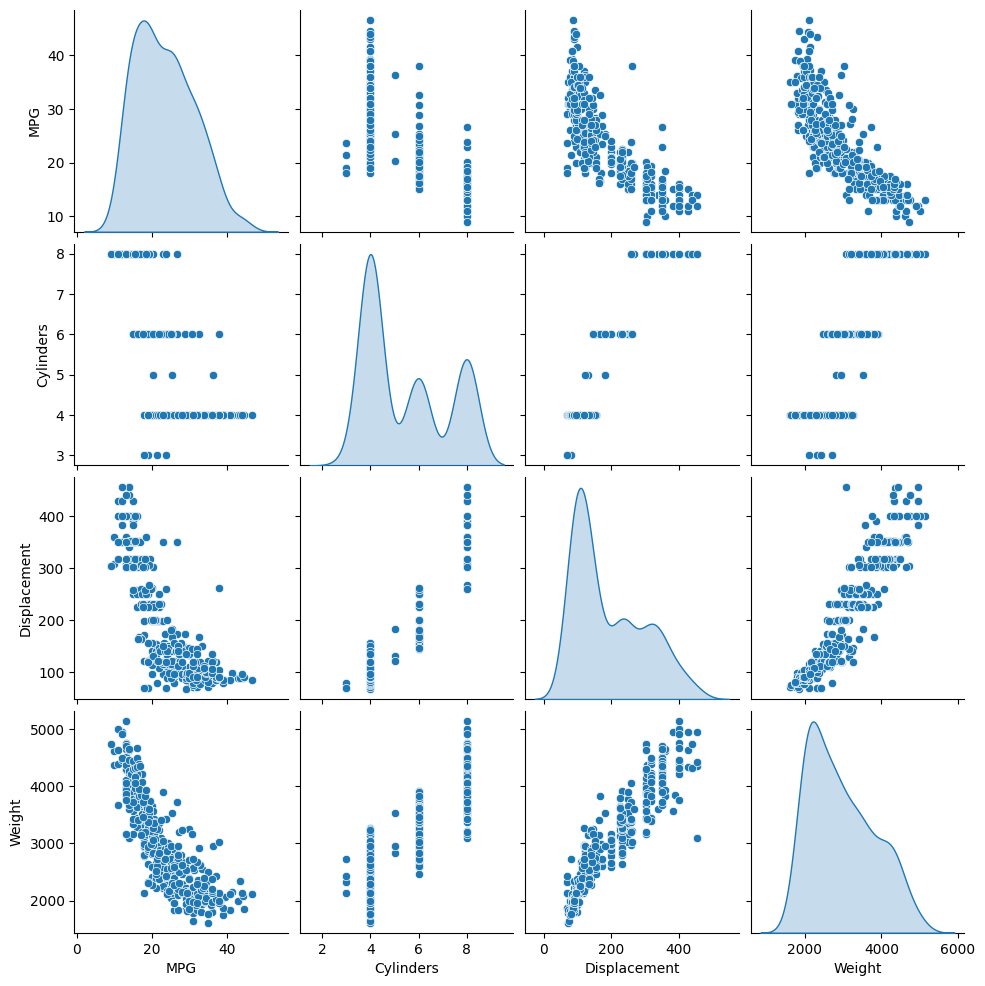

In [168]:
sns.pairplot(dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Tambien revise las estadisticas generales:

In [170]:
X_train_stats = X_train.describe()
X_train_stats = X_train_stats.transpose()
X_train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,318.0,5.452830,1.706170,3.0,4.00,4.0,8.00,8.0
Displacement,318.0,191.800314,102.795417,68.0,101.75,148.5,262.00,455.0
Horsepower,313.0,103.702875,37.723750,46.0,75.00,93.0,125.00,230.0
Weight,318.0,2963.393082,845.227078,1649.0,2216.25,2822.5,3561.25,5140.0
Acceleration,318.0,15.644654,2.701224,8.0,14.00,15.5,17.15,24.8
Model Year,318.0,76.147799,3.652083,70.0,73.00,76.0,79.00,82.0
Origin,318.0,1.591195,0.807800,1.0,1.00,1.0,2.00,3.0


### Separa las features del target

Separe el target de las features.

In [9]:
y_train,y_test=X_train.drop(columns=["MPG"]),X_test.drop(columns=["MPG"])

NameError: name 'X_train' is not defined

### Estandariza los datos

Es una buena práctica estandarizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

In [171]:
def norm(x):
    return (x - X_train_stats['mean']) / X_train_stats['std']

normed_X_train = norm(X_train)
normed_X_test = norm(X_test)
normed_X_train

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
64,1.492916,1.227678,1.227267,1.386145,-0.793956,-1.135735,-0.731858
55,-0.851515,-0.922223,-1.158498,-1.336201,1.242158,-1.409552,0.506072
317,-0.851515,-0.922223,-0.681345,-0.917378,0.057509,1.054796,0.506072
102,-0.851515,-0.922223,-1.529617,-1.198960,1.982563,-0.861919,0.506072
358,-0.851515,-0.698478,-0.787379,-0.388526,0.983016,1.328612,1.744003
...,...,...,...,...,...,...,...
323,-0.851515,-0.348268,0.034385,-0.193313,-0.460774,1.054796,-0.731858
192,0.320701,0.566170,0.034385,0.460949,-0.423754,-0.040470,-0.731858
117,-0.851515,-1.204337,-1.450091,-1.297158,1.427259,-0.861919,0.506072
47,0.320701,0.566170,-0.098158,0.376948,-0.238653,-1.409552,-0.731858


Estos datos estandarizados es lo que usaremos para entrenar el modelo.

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

Por tanto, tendrá tres capas. Una de entrada con activación relu. Otra hidden layer con activación relu y la de salida de regresión, que se compondrá de una única neurona. Pon las neuronas que consideres para las dos primeras capas.

Para el compile utiliza un loss='mse'.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

In [186]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [187]:
model = build_model()

### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [188]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 64)                512       
                                                                 
 dense_76 (Dense)            (None, 64)                4160      
                                                                 
 dense_77 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


### Entrenar el modelo

Entrene el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

NOTA: recuerda usar los datos normalizados.

In [189]:
history = model.fit(
    normed_X_train,
    y_train,
    epochs=30,
    validation_split=0.2)

Epoch 1/30
8/8 [==============================] - 1s 50ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/30
8/8 [==============================] - 0s 10ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/30
8/8 [==============================] - 0s 10ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/30
8/8 [==============================] - 0s 11ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 5/30
8/8 [==============================] - 0s 10ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 6/30
8/8 [==============================] - 0s 11ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 7/30
8/8 [==============================] - 0s 14ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [190]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,NaN,NaN,NaN,NaN,NaN,4


In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

¿Alguna conclusión respecto a este gráfico?

Añade un early stopping al modelo. Pon el argumento `callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]` dentro del fit().

Después del entrenamiento utiliza la función del apartado anterior `plot_history(history)`.

Interpreta el gráfico

Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

Ahora prueba el modelo. Coge 10 ejemplos de train y llama a` model.predict`.

### Haz Predicciones

Dibuja en un scatter plot las predicciones de test vs sus true labels.

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

Representa los residuos en un histograma

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

## Conclusion

Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana es una técnica útil para evitar el sobreajuste.